# Linear regression of the Qweak quartet asymmetries using TensorFlow

In the Qweak experiment the helicity asymmetries in the 8 main detectors are correlated to the beam parameters, in particular to the beam positions, beam slopes, beam energy, and beam current. Each main detector is read out by 2 channels, the so-called positive and negative PMT (with the sign defined by the direction in azimuthal angle).

Each data point is an integrated current over 1 ms and consists of 4 sub-measurements, the so-called sub-blocks, of 0.25 ms. The slopes of the sub-blocks with the beam parameters should be the same, and should be identical to the slopes of the sum.

The goal is to determine the beam parameter slopes for a single main detector channel and for a single runlet (~65k data points, 5 minutes of data). We will use TensorFlow for this. Why? Because we can.

In [1]:
# Setup user package dir
import sys, os, getpass
sys.path.insert(0,"/u/home/" + getpass.getuser() + "/.local/")

In [2]:
import uproot
import tensorflow as tf

In [3]:
import numpy as np
rng = np.random

In [4]:
import matplotlib.pyplot as plt

## Learning parameters

TensorFlow is a machine learning algorithm and therefore has meta parameters. First of all we have the learning rate: how does the gradient in the cost function effect a change to the model parameters? Next we have the number of epochs, or basically how many steps of training do we let the model go through?

The outcomes of this exercise will depend on the learning parameters. Changes to a different context will require changes to the learning parameters.

## Load the data

We use uproot to load the file, get the tree, and transform into numpy arrays.

In [5]:
# Parameters
learning_rate = 0.3
training_epochs = 1000
display_step = training_epochs/10

In [6]:
# Open file and get tree
tfile = uproot.open('/lustre/expphy/cache/hallc/qweak/rootfiles/pass5b/QwPass5b_18110.000.trees.root')
ttree = tfile.get("Hel_Tree")

# Choose fields of qwk to regress on
field = ['block0','block1','block2','block3']
field = 'hw_sum'

We have a fixed number of independent variables in this model. These are our X variables.

In [7]:
# Training data: X
asym_qwk_charge = ttree.array("asym_qwk_charge")[field]
diff_qwk_energy = ttree.array("diff_qwk_energy")[field]
diff_qwk_targetX = ttree.array("diff_qwk_targetX")[field]
diff_qwk_targetY = ttree.array("diff_qwk_targetY")[field]
diff_qwk_targetXSlope = ttree.array("diff_qwk_targetXSlope")[field]
diff_qwk_targetYSlope = ttree.array("diff_qwk_targetYSlope")[field]

We can choose any number of depenedent variables, but each dependent variable will get its own set of model parameters. These are our Y variables.

In [8]:
# Training data: Y
asym_qwk_md1neg = ttree.array("asym_qwk_md1neg")[field]
asym_qwk_md1pos = ttree.array("asym_qwk_md1pos")[field]

In [9]:
train_X = np.vstack((
    asym_qwk_charge,
    diff_qwk_energy,
    diff_qwk_targetX,
    diff_qwk_targetY,
    diff_qwk_targetXSlope,
    diff_qwk_targetYSlope))
train_Y = asym_qwk_md1neg
n_samples = train_X.shape[1]
n_features = train_X.shape[0]

In [10]:
# tf graph input
X = tf.placeholder("float")
Y = tf.placeholder("float")

# Set model weights
W = tf.Variable(tf.constant(0.0, shape=[n_features, 1]), name="weight")
b = tf.Variable(tf.constant(0.0, shape=[n_features, 1]), name="bias")

Our predictor function is a linear model with weights `W` and bias `b`.

In [11]:
# Construct a linear model
pred = tf.add(tf.multiply(X, W), b)

We will optimize on the cost function of the mean squared error. We use gradient descent for optimization.

In [12]:
# Mean squared error
cost = tf.reduce_sum(tf.square(tf.subtract(Y, pred)))/(2*n_samples)
# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [13]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [14]:
# Start training
with tf.Session() as sess:
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        for (x, y) in zip(train_X, train_Y):
            sess.run(optimizer, feed_dict={X: x, Y: y})

        #Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(cost, feed_dict={X: train_X, Y:train_Y})
            W_computed = sess.run(W)
            b_computed = sess.run(b)
            print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
                "W=", W_computed.flatten(), "b=", b_computed.flatten())

    print ("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: train_X, Y: train_Y})
    W_computed = sess.run(W)
    b_computed = sess.run(b)
    print ("Training cost=", training_cost, "W=", W_computed.flatten(), "b=", b_computed.flatten(), '\n')

Epoch: 0100 cost= 0.000301463 W= [-6.4853957e-06 -6.4853957e-06 -6.4853957e-06 -6.4853957e-06
 -6.4853957e-06 -6.4853957e-06] b= [0.00776734 0.00776734 0.00776734 0.00776734 0.00776734 0.00776734]
Epoch: 0200 cost= 0.000301463 W= [-1.2695081e-05 -1.2695081e-05 -1.2695081e-05 -1.2695081e-05
 -1.2695081e-05 -1.2695081e-05] b= [0.00776736 0.00776736 0.00776736 0.00776736 0.00776736 0.00776736]
Epoch: 0300 cost= 0.000301463 W= [-1.878967e-05 -1.878967e-05 -1.878967e-05 -1.878967e-05 -1.878967e-05
 -1.878967e-05] b= [0.00776735 0.00776735 0.00776735 0.00776735 0.00776735 0.00776735]
Epoch: 0400 cost= 0.000301462 W= [-2.4771387e-05 -2.4771387e-05 -2.4771387e-05 -2.4771387e-05
 -2.4771387e-05 -2.4771387e-05] b= [0.00776734 0.00776734 0.00776734 0.00776734 0.00776734 0.00776734]
Epoch: 0500 cost= 0.000301462 W= [-3.0642266e-05 -3.0642266e-05 -3.0642266e-05 -3.0642266e-05
 -3.0642266e-05 -3.0642266e-05] b= [0.00776733 0.00776733 0.00776733 0.00776733 0.00776733 0.00776733]
Epoch: 0600 cost= 0.0

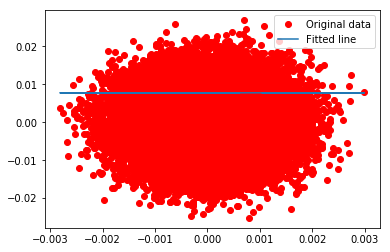

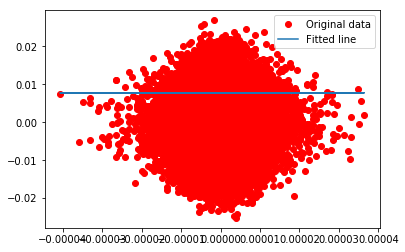

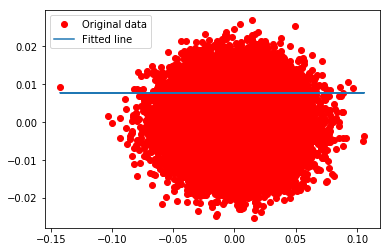

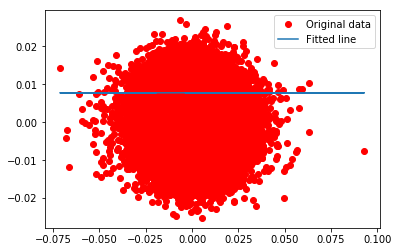

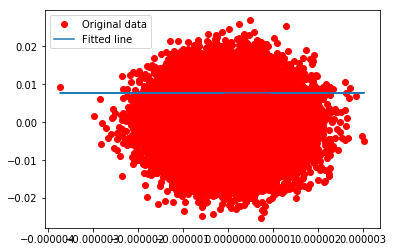

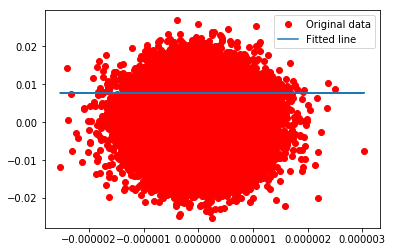

In [15]:
# Graphic display...
for feature in range(n_features):
    plt.plot(train_X[feature], train_Y, 'ro', label='Original data')
    plt.plot(train_X[feature], train_X[feature] * W_computed[feature] + b_computed[feature], label='Fitted line')
    plt.legend()
    plt.show()